In [1]:
!pip install graphviz
!pip install pydot

In [2]:
import tensorflow.keras.layers as layers
import tensorflow as tf

In [3]:
# resize images
def resize(input_image, input_mask, size=(128, 128)):
   input_image = tf.image.resize(input_image, size, method="nearest")
   input_mask = tf.image.resize(input_mask, size, method="nearest")

   return input_image, input_mask

In [ ]:
# data augmentation
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [ ]:
# normalization
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
# layer blocks
def conv_block(x, filters, kernel_size, strides=(2, 2), activation='relu',pool_size=(2,2),maxpooling=True):
  x = layers.Conv2D(filters, activation=activation, kernel_size=kernel_size)(x)
  x = layers.Conv2D(filters, activation=activation, kernel_size=kernel_size)(x)  # Skip connection으로 Expanding path로 이어질 예정
  if maxpooling==True:
    x_maxpool = layers.MaxPool2D(pool_size=pool_size, strides=strides)(x)
  else:
    x_maxpool = None
  return x, x_maxpool

def residual_block(x, y, filters, kernel_size, cropping, strides=(2, 2), activation='relu'):
  x = layers.Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, activation=activation)(x)
  y = layers.Cropping2D(cropping=cropping)(y)
  concat = layers.concatenate([x, y], axis=-1)
  return concat

In [ ]:
def unet(input_shape=(572, 572, 1)):
  inputs = layers.Input(shape=input_shape)

  # Encoder
  x_0 = inputs
  x_1, x_1_maxpool = conv_block(x_0, 64, kernel_size=3, strides=(2,2)) # [1]
  x_2, x_2_maxpool = conv_block(x_1_maxpool, 128, kernel_size=3, strides=(2,2)) # [2]
  x_3, x_3_maxpool = conv_block(x_2_maxpool, 256, kernel_size=3, strides=(2,2)) # [3]
  x_4, x_4_maxpool = conv_block(x_3_maxpool, 512, kernel_size=3, strides=(2,2)) # [4]
  x_5, _ = conv_block(x_4_maxpool, 1024, kernel_size=3, strides=(2,2), maxpooling=False) # [5]

  # Skip connection & Decoder
  x_6 = residual_block(x_5, x_4, 512, 2, cropping=(4,4)) # [6]
  x_7, _ = conv_block(x_6, 512, kernel_size=3, maxpooling=False) # [7]
  x_8 = residual_block(x_7, x_3, 256, 2, cropping=(16,16)) # [8]
  x_9, _ = conv_block(x_8, 256, kernel_size=3, maxpooling=False) # [9]
  x_10 = residual_block(x_9, x_2, 128, 2, cropping=(40,40)) # [10]
  x_11, _ = conv_block(x_10, 128, kernel_size=3, maxpooling=False) # [11]
  x_12 = residual_block(x_11, x_1, 64, 2, cropping=(88,88)) # [12]
  x_13, _ = conv_block(x_12, 64, kernel_size=3, maxpooling=False) #[13]

  # Output
  outputs = layers.Conv2D(2, kernel_size=1)(x_13)
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-net")

  return model



In [ ]:
model = unet()
model.summary()

Model: "u-net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 572, 572, 1)]        0         []                            
                                                                                                  
 conv2d_70 (Conv2D)          (None, 570, 570, 64)         640       ['input_7[0][0]']             
                                                                                                  
 conv2d_71 (Conv2D)          (None, 568, 568, 64)         36928     ['conv2d_70[0][0]']           
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 284, 284, 64)         0         ['conv2d_71[0][0]']           
 ng2D)                                                                                        

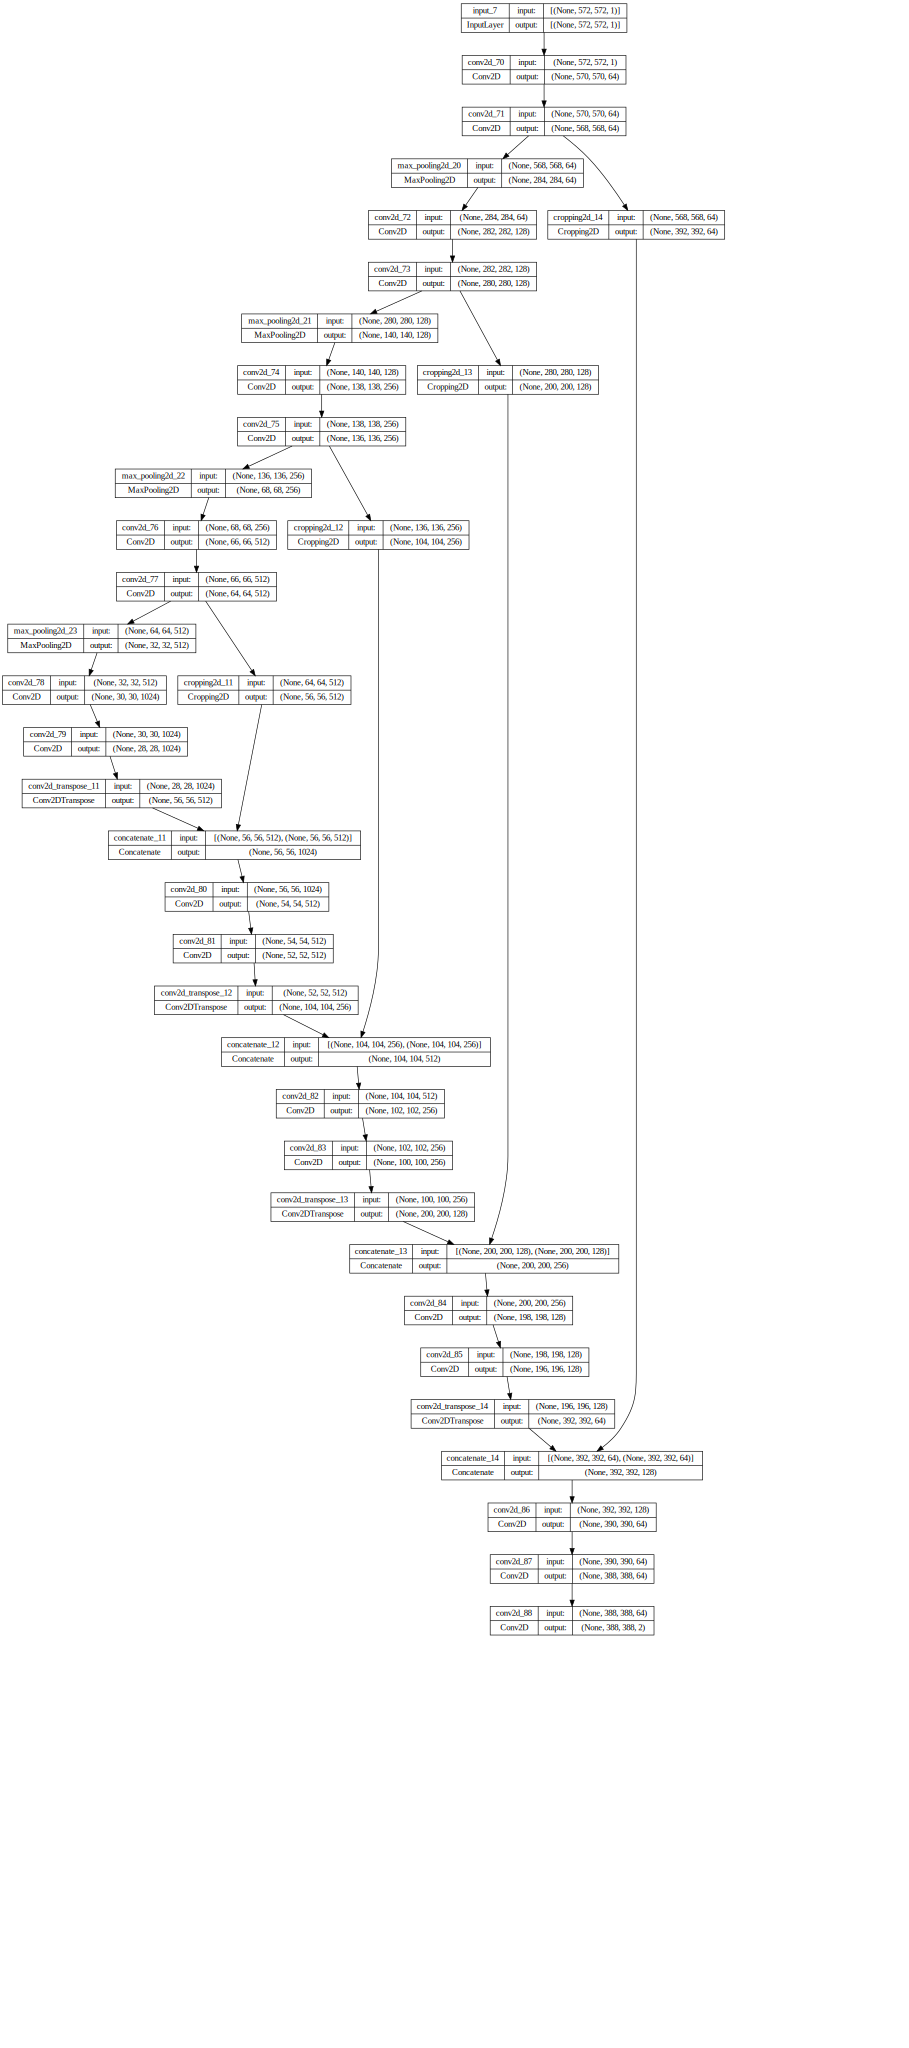

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=120).create(prog='dot', format='svg'))  #dpi를 작게 하면 그래프가 커집니다.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)